## Advisory 
### If you have not yet begun the project 
Please do not use this workspace.  Use the AWS resources provided and the instructions from the [cloud computing lesson](https://classroom.udacity.com/nanodegrees/nd101/parts/b9c4c3c3-b524-427b-8832-9d0748f14a2e/modules/de12f7bf-d980-4998-ab91-0e411184c878/lessons/29df00d8-01c2-4995-92fa-a4afd020be90/concepts/80d2ed46-1bba-413e-891e-610259017251).
### If you have started on this workspace
Please consider downloading your Jupyter notebook and then following the instructions above on using AWS instead.  You can upload your current work to AWS through your GitHub account.  


As a reminder, the project can be found on the [deep learning GitHub page](https://github.com/udacity/deep-learning/tree/master/face_generation).
These warnings are given because the project frequently generates more data than the workspace can handle, causing loading problems and lost work.  Please use [the forums](https://discussions.udacity.com/c/nd101-part-5-GANs/nd101-generate-faces) if you have any questions on the project or its setup.


# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


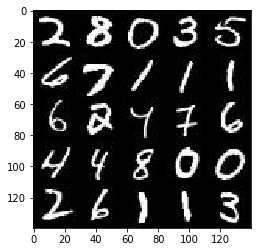

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

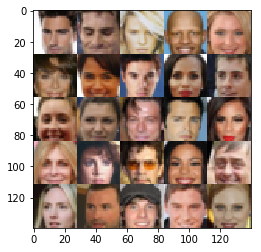

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 'real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), 'z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # 1st layer 28 x 28 x out_channel_dim
        x1 = tf.layers.conv2d(images, 64, 5, 2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # Now 14 x 14 x 64
        
        # 2nd layer 
        x2 = tf.layers.conv2d(x1, 128, 5, 2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # Now 7 x 7 x 128
        
        # 3d layer 
        x3 = tf.layers.conv2d(x2, 256, 5, 1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # Now 7 x 7 x 256
        
        # Flatten the 3rd layer
        x3 = tf.reshape(x3, (-1, 7*7*256))
        
        # 4th layer
        logits = tf.layers.dense(x3, 1)
        output = tf.sigmoid(logits)
        
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # 1st layer 
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # Now 7 x 7 x 512

        # 2nd layer 
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # Now 14 x 14 x 256
        
        # 3rd layer 
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # Now 28 x 28 x 128

        # 4th layer
        x4 = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 1, padding='same')
        x4 = tf.tanh(x4)
        # Now 28 x 28 x out_channel_dim

        return x4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generator_output = generator(input_z, out_channel_dim)
    
    output_real, logits_real = discriminator(input_real)
    output_fake, logits_fake = discriminator(generator_output, reuse=True)
    
    # We use here label smoothing
    d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(logits_real) * 0.9)
    d_loss_real = tf.reduce_mean(d_loss_real)
    
    d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.zeros_like(logits_fake))
    d_loss_fake = tf.reduce_mean(d_loss_fake)
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.ones_like(logits_fake))
    g_loss = tf.reduce_mean(g_loss)
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable_vars = tf.trainable_variables()
    generator_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    discriminator_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_optimizer = tf.train.AdamOptimizer(beta1=beta1).minimize(d_loss, var_list=discriminator_vars)
        g_optimizer = tf.train.AdamOptimizer(beta1=beta1).minimize(g_loss, var_list=generator_vars)
    
    return d_optimizer, g_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

z_dim = 100
n_images = 16
example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

def show_generator_output(sess, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Image size and color channels
    img_width, img_height, img_channels = data_shape[1:4]
    
    # Model inputs
    real_input, z_input, l_rate = model_inputs(img_width, img_height, img_channels, z_dim)
    
    # Loss functions
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    
    # Optimizers
    d_optimizer, g_optimizer = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Saver
    saver = tf.train.Saver()
    
    # Counter
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Scale images in the range from -1 to 1
                batch_images = batch_images * 2
                
                # Generate noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_optimizer, feed_dict={real_input: batch_images, 
                                                     z_input: batch_z, 
                                                     l_rate: learning_rate})
                _ = sess.run(g_optimizer, feed_dict={real_input: batch_images,
                                                     z_input: batch_z,
                                                     l_rate: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({real_input: batch_images, z_input: batch_z})
                    train_loss_g = g_loss.eval({real_input: batch_images, z_input: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}...".format(train_loss_g), 
                          "Total Loss: {:.4f}".format(train_loss_d + train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, z_input, img_channels, data_image_mode)
        
        print('Training finished.')
        # Last epoch
        show_generator_output(sess, z_input, img_channels, data_image_mode)
        saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3047... Generator Loss: 14.6945... Total Loss: 15.9993
Epoch 1/2... Discriminator Loss: 0.5400... Generator Loss: 3.9109... Total Loss: 4.4510
Epoch 1/2... Discriminator Loss: 0.9507... Generator Loss: 1.7419... Total Loss: 2.6925
Epoch 1/2... Discriminator Loss: 2.2348... Generator Loss: 0.6341... Total Loss: 2.8689
Epoch 1/2... Discriminator Loss: 1.0583... Generator Loss: 1.6975... Total Loss: 2.7557
Epoch 1/2... Discriminator Loss: 2.3251... Generator Loss: 0.4874... Total Loss: 2.8124
Epoch 1/2... Discriminator Loss: 0.7178... Generator Loss: 1.8642... Total Loss: 2.5820
Epoch 1/2... Discriminator Loss: 0.9990... Generator Loss: 3.4461... Total Loss: 4.4451
Epoch 1/2... Discriminator Loss: 1.4365... Generator Loss: 0.6744... Total Loss: 2.1109
Epoch 1/2... Discriminator Loss: 1.3778... Generator Loss: 0.9567... Total Loss: 2.3345


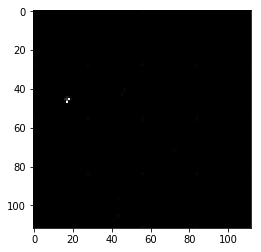

Epoch 1/2... Discriminator Loss: 1.2455... Generator Loss: 2.0913... Total Loss: 3.3368
Epoch 1/2... Discriminator Loss: 1.3791... Generator Loss: 0.6895... Total Loss: 2.0686
Epoch 1/2... Discriminator Loss: 1.5213... Generator Loss: 2.9618... Total Loss: 4.4831
Epoch 1/2... Discriminator Loss: 1.0751... Generator Loss: 1.0569... Total Loss: 2.1320
Epoch 1/2... Discriminator Loss: 2.0413... Generator Loss: 0.3994... Total Loss: 2.4408
Epoch 1/2... Discriminator Loss: 1.3230... Generator Loss: 1.1819... Total Loss: 2.5049
Epoch 1/2... Discriminator Loss: 0.9393... Generator Loss: 1.0466... Total Loss: 1.9859
Epoch 1/2... Discriminator Loss: 1.1014... Generator Loss: 2.5929... Total Loss: 3.6943
Epoch 1/2... Discriminator Loss: 1.4394... Generator Loss: 0.6233... Total Loss: 2.0627
Epoch 1/2... Discriminator Loss: 1.4373... Generator Loss: 0.5445... Total Loss: 1.9818


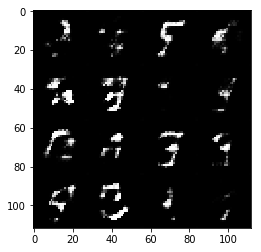

Epoch 1/2... Discriminator Loss: 1.4766... Generator Loss: 0.6365... Total Loss: 2.1131
Epoch 1/2... Discriminator Loss: 1.4864... Generator Loss: 1.9508... Total Loss: 3.4371
Epoch 1/2... Discriminator Loss: 1.3442... Generator Loss: 1.1107... Total Loss: 2.4549
Epoch 1/2... Discriminator Loss: 1.0596... Generator Loss: 1.6384... Total Loss: 2.6980
Epoch 1/2... Discriminator Loss: 2.0149... Generator Loss: 3.5431... Total Loss: 5.5581
Epoch 1/2... Discriminator Loss: 1.4044... Generator Loss: 3.5703... Total Loss: 4.9747
Epoch 1/2... Discriminator Loss: 1.1847... Generator Loss: 1.9447... Total Loss: 3.1294
Epoch 1/2... Discriminator Loss: 1.1323... Generator Loss: 0.9196... Total Loss: 2.0520
Epoch 1/2... Discriminator Loss: 1.4758... Generator Loss: 0.6358... Total Loss: 2.1115
Epoch 1/2... Discriminator Loss: 1.0631... Generator Loss: 1.1150... Total Loss: 2.1781


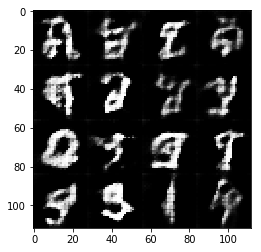

Epoch 1/2... Discriminator Loss: 1.5300... Generator Loss: 1.8138... Total Loss: 3.3437
Epoch 1/2... Discriminator Loss: 1.1064... Generator Loss: 1.0269... Total Loss: 2.1333
Epoch 1/2... Discriminator Loss: 1.3534... Generator Loss: 0.6330... Total Loss: 1.9864
Epoch 1/2... Discriminator Loss: 1.9993... Generator Loss: 0.2681... Total Loss: 2.2673
Epoch 1/2... Discriminator Loss: 1.3438... Generator Loss: 0.7522... Total Loss: 2.0960
Epoch 1/2... Discriminator Loss: 1.2681... Generator Loss: 0.8239... Total Loss: 2.0920
Epoch 1/2... Discriminator Loss: 1.6629... Generator Loss: 0.4019... Total Loss: 2.0648
Epoch 1/2... Discriminator Loss: 1.3525... Generator Loss: 1.4286... Total Loss: 2.7811
Epoch 1/2... Discriminator Loss: 1.7391... Generator Loss: 1.4526... Total Loss: 3.1917
Epoch 1/2... Discriminator Loss: 1.0761... Generator Loss: 1.4920... Total Loss: 2.5681


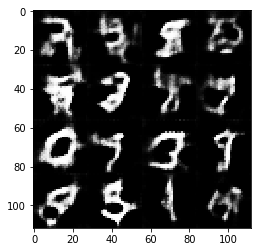

Epoch 1/2... Discriminator Loss: 1.1661... Generator Loss: 1.2952... Total Loss: 2.4613
Epoch 1/2... Discriminator Loss: 1.3401... Generator Loss: 0.6549... Total Loss: 1.9950
Epoch 1/2... Discriminator Loss: 1.2806... Generator Loss: 0.6376... Total Loss: 1.9183
Epoch 1/2... Discriminator Loss: 1.3141... Generator Loss: 1.7404... Total Loss: 3.0545
Epoch 1/2... Discriminator Loss: 1.2646... Generator Loss: 0.8785... Total Loss: 2.1432
Epoch 1/2... Discriminator Loss: 1.2395... Generator Loss: 0.7831... Total Loss: 2.0226
Epoch 1/2... Discriminator Loss: 1.4952... Generator Loss: 0.5109... Total Loss: 2.0061
Epoch 1/2... Discriminator Loss: 2.0273... Generator Loss: 0.3042... Total Loss: 2.3315
Epoch 1/2... Discriminator Loss: 1.5951... Generator Loss: 1.8626... Total Loss: 3.4577
Epoch 1/2... Discriminator Loss: 1.1697... Generator Loss: 0.8120... Total Loss: 1.9818


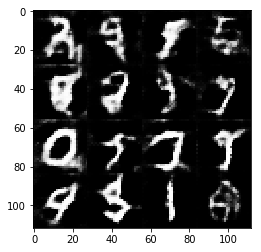

Epoch 1/2... Discriminator Loss: 1.1655... Generator Loss: 0.9102... Total Loss: 2.0757
Epoch 1/2... Discriminator Loss: 1.0616... Generator Loss: 1.4226... Total Loss: 2.4843
Epoch 1/2... Discriminator Loss: 1.3025... Generator Loss: 0.7420... Total Loss: 2.0445
Epoch 1/2... Discriminator Loss: 1.2830... Generator Loss: 0.8434... Total Loss: 2.1264
Epoch 1/2... Discriminator Loss: 1.6213... Generator Loss: 0.5256... Total Loss: 2.1469
Epoch 1/2... Discriminator Loss: 1.3819... Generator Loss: 1.5346... Total Loss: 2.9165
Epoch 1/2... Discriminator Loss: 1.4385... Generator Loss: 0.6746... Total Loss: 2.1132
Epoch 1/2... Discriminator Loss: 1.0032... Generator Loss: 1.1623... Total Loss: 2.1655
Epoch 1/2... Discriminator Loss: 1.5312... Generator Loss: 0.4537... Total Loss: 1.9849
Epoch 1/2... Discriminator Loss: 1.4440... Generator Loss: 2.0527... Total Loss: 3.4967


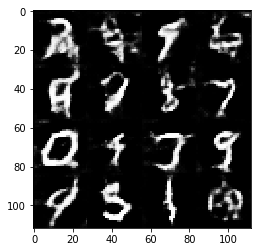

Epoch 1/2... Discriminator Loss: 1.8699... Generator Loss: 0.4475... Total Loss: 2.3174
Epoch 1/2... Discriminator Loss: 1.9045... Generator Loss: 2.4875... Total Loss: 4.3919
Epoch 1/2... Discriminator Loss: 1.1717... Generator Loss: 1.0037... Total Loss: 2.1755
Epoch 1/2... Discriminator Loss: 1.3933... Generator Loss: 0.6128... Total Loss: 2.0061
Epoch 1/2... Discriminator Loss: 1.1589... Generator Loss: 1.0624... Total Loss: 2.2212
Epoch 1/2... Discriminator Loss: 1.6045... Generator Loss: 0.4702... Total Loss: 2.0747
Epoch 1/2... Discriminator Loss: 1.2540... Generator Loss: 1.4623... Total Loss: 2.7162
Epoch 1/2... Discriminator Loss: 1.2658... Generator Loss: 0.7914... Total Loss: 2.0572
Epoch 1/2... Discriminator Loss: 1.1274... Generator Loss: 0.7806... Total Loss: 1.9079
Epoch 1/2... Discriminator Loss: 1.4306... Generator Loss: 0.8367... Total Loss: 2.2673


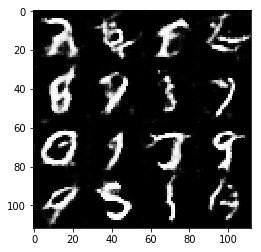

Epoch 1/2... Discriminator Loss: 1.2251... Generator Loss: 1.4549... Total Loss: 2.6801
Epoch 1/2... Discriminator Loss: 1.3785... Generator Loss: 0.5813... Total Loss: 1.9598
Epoch 1/2... Discriminator Loss: 1.3424... Generator Loss: 0.6369... Total Loss: 1.9793
Epoch 1/2... Discriminator Loss: 1.2711... Generator Loss: 0.7026... Total Loss: 1.9737
Epoch 1/2... Discriminator Loss: 2.0827... Generator Loss: 2.8274... Total Loss: 4.9101
Epoch 1/2... Discriminator Loss: 1.2571... Generator Loss: 1.1468... Total Loss: 2.4039
Epoch 1/2... Discriminator Loss: 1.2109... Generator Loss: 1.0350... Total Loss: 2.2460
Epoch 1/2... Discriminator Loss: 1.3336... Generator Loss: 0.6662... Total Loss: 1.9998
Epoch 1/2... Discriminator Loss: 1.4844... Generator Loss: 0.4981... Total Loss: 1.9825
Epoch 1/2... Discriminator Loss: 1.0946... Generator Loss: 1.0700... Total Loss: 2.1647


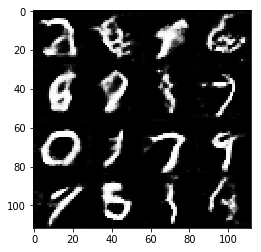

Epoch 1/2... Discriminator Loss: 1.8709... Generator Loss: 0.3717... Total Loss: 2.2426
Epoch 1/2... Discriminator Loss: 1.2048... Generator Loss: 0.7965... Total Loss: 2.0014
Epoch 1/2... Discriminator Loss: 1.2228... Generator Loss: 0.9298... Total Loss: 2.1527
Epoch 1/2... Discriminator Loss: 1.3007... Generator Loss: 0.6746... Total Loss: 1.9753
Epoch 1/2... Discriminator Loss: 1.6177... Generator Loss: 0.4182... Total Loss: 2.0359
Epoch 1/2... Discriminator Loss: 1.3267... Generator Loss: 1.9200... Total Loss: 3.2466
Epoch 1/2... Discriminator Loss: 1.2317... Generator Loss: 0.7495... Total Loss: 1.9812
Epoch 1/2... Discriminator Loss: 1.0074... Generator Loss: 1.0064... Total Loss: 2.0138
Epoch 1/2... Discriminator Loss: 1.1487... Generator Loss: 1.5694... Total Loss: 2.7181
Epoch 1/2... Discriminator Loss: 1.0515... Generator Loss: 1.0472... Total Loss: 2.0987


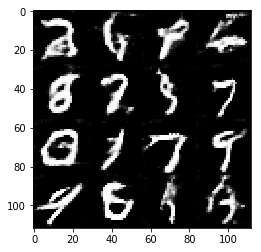

Epoch 1/2... Discriminator Loss: 1.1945... Generator Loss: 0.7647... Total Loss: 1.9592
Epoch 1/2... Discriminator Loss: 1.2760... Generator Loss: 0.8902... Total Loss: 2.1663
Epoch 1/2... Discriminator Loss: 1.4518... Generator Loss: 0.6038... Total Loss: 2.0556
Epoch 1/2... Discriminator Loss: 1.2252... Generator Loss: 0.7933... Total Loss: 2.0185
Epoch 1/2... Discriminator Loss: 1.2697... Generator Loss: 1.0356... Total Loss: 2.3053
Epoch 1/2... Discriminator Loss: 1.7002... Generator Loss: 0.3468... Total Loss: 2.0470
Epoch 1/2... Discriminator Loss: 1.2811... Generator Loss: 1.4400... Total Loss: 2.7212
Epoch 1/2... Discriminator Loss: 1.1378... Generator Loss: 1.0174... Total Loss: 2.1552
Epoch 1/2... Discriminator Loss: 1.0411... Generator Loss: 1.0783... Total Loss: 2.1194
Epoch 1/2... Discriminator Loss: 1.2442... Generator Loss: 1.5757... Total Loss: 2.8199


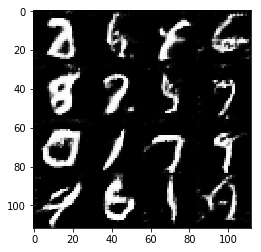

Epoch 1/2... Discriminator Loss: 1.1452... Generator Loss: 0.7431... Total Loss: 1.8883
Epoch 1/2... Discriminator Loss: 1.4291... Generator Loss: 1.8351... Total Loss: 3.2642
Epoch 1/2... Discriminator Loss: 1.2186... Generator Loss: 0.7099... Total Loss: 1.9285
Epoch 1/2... Discriminator Loss: 1.3825... Generator Loss: 0.5697... Total Loss: 1.9521
Epoch 1/2... Discriminator Loss: 0.9841... Generator Loss: 1.6828... Total Loss: 2.6670
Epoch 1/2... Discriminator Loss: 1.1064... Generator Loss: 0.8608... Total Loss: 1.9673
Epoch 1/2... Discriminator Loss: 2.4100... Generator Loss: 0.1929... Total Loss: 2.6028
Epoch 1/2... Discriminator Loss: 2.1521... Generator Loss: 0.2749... Total Loss: 2.4270
Epoch 1/2... Discriminator Loss: 1.1489... Generator Loss: 1.0494... Total Loss: 2.1983
Epoch 1/2... Discriminator Loss: 1.2560... Generator Loss: 1.4199... Total Loss: 2.6758


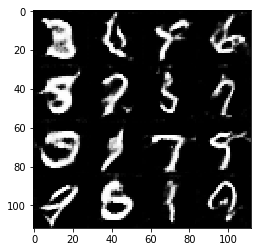

Epoch 1/2... Discriminator Loss: 1.9005... Generator Loss: 0.2904... Total Loss: 2.1910
Epoch 1/2... Discriminator Loss: 1.3315... Generator Loss: 0.7035... Total Loss: 2.0350
Epoch 1/2... Discriminator Loss: 1.1518... Generator Loss: 1.0310... Total Loss: 2.1828
Epoch 1/2... Discriminator Loss: 1.3454... Generator Loss: 1.8864... Total Loss: 3.2318
Epoch 1/2... Discriminator Loss: 1.2053... Generator Loss: 0.7237... Total Loss: 1.9291
Epoch 1/2... Discriminator Loss: 1.8722... Generator Loss: 2.6853... Total Loss: 4.5575
Epoch 1/2... Discriminator Loss: 1.4905... Generator Loss: 0.4720... Total Loss: 1.9625
Epoch 1/2... Discriminator Loss: 1.1754... Generator Loss: 1.9180... Total Loss: 3.0934
Epoch 1/2... Discriminator Loss: 1.8755... Generator Loss: 0.3194... Total Loss: 2.1949
Epoch 1/2... Discriminator Loss: 1.2284... Generator Loss: 0.6909... Total Loss: 1.9193


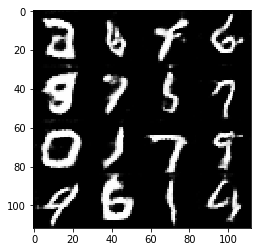

Epoch 1/2... Discriminator Loss: 1.2843... Generator Loss: 0.6704... Total Loss: 1.9547
Epoch 1/2... Discriminator Loss: 1.6894... Generator Loss: 0.3821... Total Loss: 2.0715
Epoch 1/2... Discriminator Loss: 1.3473... Generator Loss: 0.6413... Total Loss: 1.9886
Epoch 1/2... Discriminator Loss: 1.6573... Generator Loss: 0.3713... Total Loss: 2.0286
Epoch 1/2... Discriminator Loss: 1.5707... Generator Loss: 2.5974... Total Loss: 4.1681
Epoch 1/2... Discriminator Loss: 1.2346... Generator Loss: 0.8693... Total Loss: 2.1039
Epoch 1/2... Discriminator Loss: 1.1939... Generator Loss: 1.7017... Total Loss: 2.8957
Epoch 1/2... Discriminator Loss: 1.0410... Generator Loss: 1.3474... Total Loss: 2.3883
Epoch 1/2... Discriminator Loss: 1.2139... Generator Loss: 1.1892... Total Loss: 2.4031
Epoch 1/2... Discriminator Loss: 1.1248... Generator Loss: 0.8870... Total Loss: 2.0118


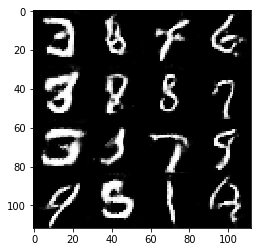

Epoch 1/2... Discriminator Loss: 1.6364... Generator Loss: 0.4238... Total Loss: 2.0602
Epoch 1/2... Discriminator Loss: 1.1039... Generator Loss: 1.5973... Total Loss: 2.7012
Epoch 1/2... Discriminator Loss: 1.2030... Generator Loss: 1.2810... Total Loss: 2.4839
Epoch 1/2... Discriminator Loss: 1.3286... Generator Loss: 0.5737... Total Loss: 1.9023
Epoch 1/2... Discriminator Loss: 1.0254... Generator Loss: 1.0857... Total Loss: 2.1111
Epoch 1/2... Discriminator Loss: 1.3745... Generator Loss: 1.5802... Total Loss: 2.9547
Epoch 1/2... Discriminator Loss: 1.0647... Generator Loss: 0.9888... Total Loss: 2.0535
Epoch 1/2... Discriminator Loss: 1.2370... Generator Loss: 0.9588... Total Loss: 2.1958
Epoch 1/2... Discriminator Loss: 1.2894... Generator Loss: 0.6868... Total Loss: 1.9762
Epoch 1/2... Discriminator Loss: 1.0840... Generator Loss: 1.2490... Total Loss: 2.3330


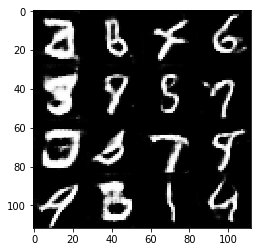

Epoch 1/2... Discriminator Loss: 1.4291... Generator Loss: 0.5457... Total Loss: 1.9747
Epoch 1/2... Discriminator Loss: 1.0653... Generator Loss: 1.0924... Total Loss: 2.1576
Epoch 1/2... Discriminator Loss: 1.2584... Generator Loss: 0.6748... Total Loss: 1.9332
Epoch 1/2... Discriminator Loss: 0.8922... Generator Loss: 1.5322... Total Loss: 2.4244
Epoch 1/2... Discriminator Loss: 1.2070... Generator Loss: 0.7329... Total Loss: 1.9399
Epoch 1/2... Discriminator Loss: 2.2455... Generator Loss: 0.2259... Total Loss: 2.4714
Epoch 1/2... Discriminator Loss: 1.2172... Generator Loss: 0.8654... Total Loss: 2.0826
Epoch 1/2... Discriminator Loss: 1.2202... Generator Loss: 0.6982... Total Loss: 1.9184
Epoch 1/2... Discriminator Loss: 1.2808... Generator Loss: 0.6839... Total Loss: 1.9647
Epoch 1/2... Discriminator Loss: 1.2459... Generator Loss: 0.8766... Total Loss: 2.1225


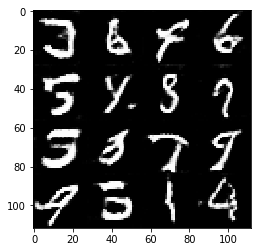

Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 0.5962... Total Loss: 1.9769
Epoch 1/2... Discriminator Loss: 1.4167... Generator Loss: 0.5935... Total Loss: 2.0102
Epoch 1/2... Discriminator Loss: 1.9063... Generator Loss: 0.3221... Total Loss: 2.2285
Epoch 1/2... Discriminator Loss: 1.0236... Generator Loss: 1.3329... Total Loss: 2.3565
Epoch 1/2... Discriminator Loss: 1.2687... Generator Loss: 2.0391... Total Loss: 3.3078
Epoch 1/2... Discriminator Loss: 1.3309... Generator Loss: 0.5813... Total Loss: 1.9122
Epoch 1/2... Discriminator Loss: 1.1216... Generator Loss: 0.8858... Total Loss: 2.0074
Epoch 1/2... Discriminator Loss: 1.2912... Generator Loss: 0.8945... Total Loss: 2.1857
Epoch 1/2... Discriminator Loss: 1.0283... Generator Loss: 1.3363... Total Loss: 2.3646
Epoch 1/2... Discriminator Loss: 1.1256... Generator Loss: 0.8219... Total Loss: 1.9475


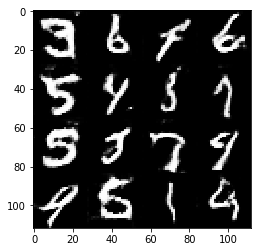

Epoch 1/2... Discriminator Loss: 0.9982... Generator Loss: 0.9108... Total Loss: 1.9090
Epoch 1/2... Discriminator Loss: 1.1487... Generator Loss: 1.9589... Total Loss: 3.1075
Epoch 1/2... Discriminator Loss: 1.1090... Generator Loss: 1.0408... Total Loss: 2.1498
Epoch 1/2... Discriminator Loss: 1.0894... Generator Loss: 1.4006... Total Loss: 2.4900
Epoch 1/2... Discriminator Loss: 1.3234... Generator Loss: 0.6553... Total Loss: 1.9787
Epoch 1/2... Discriminator Loss: 2.4165... Generator Loss: 3.5424... Total Loss: 5.9589
Epoch 1/2... Discriminator Loss: 1.1015... Generator Loss: 1.1967... Total Loss: 2.2982
Epoch 1/2... Discriminator Loss: 2.0803... Generator Loss: 0.2896... Total Loss: 2.3699
Epoch 1/2... Discriminator Loss: 1.0686... Generator Loss: 1.0092... Total Loss: 2.0778
Epoch 1/2... Discriminator Loss: 1.2380... Generator Loss: 0.7947... Total Loss: 2.0328


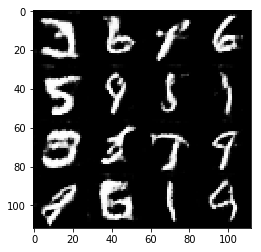

Epoch 1/2... Discriminator Loss: 1.3346... Generator Loss: 3.9379... Total Loss: 5.2724
Epoch 1/2... Discriminator Loss: 1.7080... Generator Loss: 0.3662... Total Loss: 2.0742
Epoch 1/2... Discriminator Loss: 0.9239... Generator Loss: 1.1702... Total Loss: 2.0941
Epoch 1/2... Discriminator Loss: 1.3083... Generator Loss: 1.5678... Total Loss: 2.8761
Epoch 1/2... Discriminator Loss: 0.9392... Generator Loss: 1.7397... Total Loss: 2.6789
Epoch 1/2... Discriminator Loss: 1.0894... Generator Loss: 0.8575... Total Loss: 1.9469
Epoch 1/2... Discriminator Loss: 1.6537... Generator Loss: 2.8357... Total Loss: 4.4894
Epoch 1/2... Discriminator Loss: 1.2831... Generator Loss: 0.8097... Total Loss: 2.0927
Epoch 1/2... Discriminator Loss: 1.3518... Generator Loss: 0.6438... Total Loss: 1.9956
Epoch 1/2... Discriminator Loss: 0.9561... Generator Loss: 1.4325... Total Loss: 2.3886


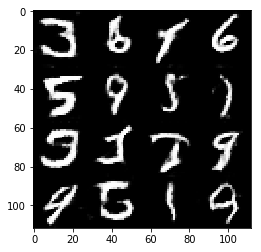

Epoch 1/2... Discriminator Loss: 1.6225... Generator Loss: 0.4943... Total Loss: 2.1168
Epoch 1/2... Discriminator Loss: 0.8613... Generator Loss: 1.6035... Total Loss: 2.4648
Epoch 1/2... Discriminator Loss: 1.5196... Generator Loss: 1.6839... Total Loss: 3.2036
Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 1.2178... Total Loss: 2.2510
Epoch 1/2... Discriminator Loss: 1.1993... Generator Loss: 0.7192... Total Loss: 1.9186
Epoch 1/2... Discriminator Loss: 1.2680... Generator Loss: 2.9066... Total Loss: 4.1747
Epoch 1/2... Discriminator Loss: 1.3744... Generator Loss: 0.5191... Total Loss: 1.8935
Epoch 2/2... Discriminator Loss: 1.0028... Generator Loss: 1.3337... Total Loss: 2.3364
Epoch 2/2... Discriminator Loss: 1.1773... Generator Loss: 1.5382... Total Loss: 2.7156
Epoch 2/2... Discriminator Loss: 0.8015... Generator Loss: 1.6939... Total Loss: 2.4954


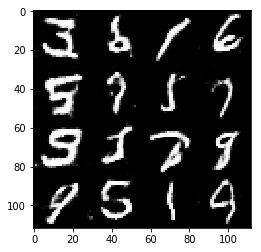

Epoch 2/2... Discriminator Loss: 0.9563... Generator Loss: 1.7808... Total Loss: 2.7371
Epoch 2/2... Discriminator Loss: 1.1627... Generator Loss: 2.5589... Total Loss: 3.7216
Epoch 2/2... Discriminator Loss: 0.8569... Generator Loss: 1.7987... Total Loss: 2.6556
Epoch 2/2... Discriminator Loss: 0.9664... Generator Loss: 1.0794... Total Loss: 2.0458
Epoch 2/2... Discriminator Loss: 1.1738... Generator Loss: 1.5410... Total Loss: 2.7147
Epoch 2/2... Discriminator Loss: 0.8248... Generator Loss: 1.5108... Total Loss: 2.3356
Epoch 2/2... Discriminator Loss: 2.4349... Generator Loss: 0.2207... Total Loss: 2.6556
Epoch 2/2... Discriminator Loss: 1.9126... Generator Loss: 0.3473... Total Loss: 2.2599
Epoch 2/2... Discriminator Loss: 0.9041... Generator Loss: 1.1483... Total Loss: 2.0523
Epoch 2/2... Discriminator Loss: 1.3501... Generator Loss: 0.6251... Total Loss: 1.9752


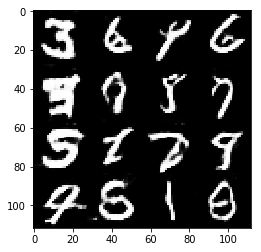

Epoch 2/2... Discriminator Loss: 1.7068... Generator Loss: 0.4016... Total Loss: 2.1084
Epoch 2/2... Discriminator Loss: 1.2392... Generator Loss: 2.2428... Total Loss: 3.4820
Epoch 2/2... Discriminator Loss: 0.9964... Generator Loss: 1.0934... Total Loss: 2.0898
Epoch 2/2... Discriminator Loss: 1.1683... Generator Loss: 0.8220... Total Loss: 1.9903
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 1.2391... Total Loss: 2.2455
Epoch 2/2... Discriminator Loss: 0.8110... Generator Loss: 1.7585... Total Loss: 2.5694
Epoch 2/2... Discriminator Loss: 1.4093... Generator Loss: 0.4947... Total Loss: 1.9040
Epoch 2/2... Discriminator Loss: 1.1610... Generator Loss: 0.7993... Total Loss: 1.9603
Epoch 2/2... Discriminator Loss: 1.4097... Generator Loss: 0.6852... Total Loss: 2.0949
Epoch 2/2... Discriminator Loss: 1.0092... Generator Loss: 0.9648... Total Loss: 1.9741


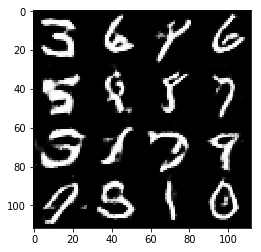

Epoch 2/2... Discriminator Loss: 1.0495... Generator Loss: 0.9730... Total Loss: 2.0225
Epoch 2/2... Discriminator Loss: 1.1721... Generator Loss: 0.8187... Total Loss: 1.9908
Epoch 2/2... Discriminator Loss: 0.8881... Generator Loss: 1.6616... Total Loss: 2.5498
Epoch 2/2... Discriminator Loss: 1.3947... Generator Loss: 0.6701... Total Loss: 2.0648
Epoch 2/2... Discriminator Loss: 1.2592... Generator Loss: 2.5544... Total Loss: 3.8136
Epoch 2/2... Discriminator Loss: 1.2723... Generator Loss: 0.8269... Total Loss: 2.0992
Epoch 2/2... Discriminator Loss: 0.8695... Generator Loss: 1.3918... Total Loss: 2.2613
Epoch 2/2... Discriminator Loss: 0.7981... Generator Loss: 1.5936... Total Loss: 2.3917
Epoch 2/2... Discriminator Loss: 1.0987... Generator Loss: 1.2375... Total Loss: 2.3362
Epoch 2/2... Discriminator Loss: 0.8724... Generator Loss: 1.6318... Total Loss: 2.5042


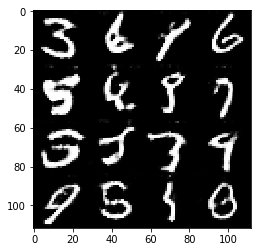

Epoch 2/2... Discriminator Loss: 1.0943... Generator Loss: 0.9874... Total Loss: 2.0817
Epoch 2/2... Discriminator Loss: 1.3790... Generator Loss: 0.5991... Total Loss: 1.9781
Epoch 2/2... Discriminator Loss: 0.9401... Generator Loss: 1.0896... Total Loss: 2.0297
Epoch 2/2... Discriminator Loss: 1.0831... Generator Loss: 1.7998... Total Loss: 2.8829
Epoch 2/2... Discriminator Loss: 1.2155... Generator Loss: 0.7270... Total Loss: 1.9425
Epoch 2/2... Discriminator Loss: 0.6990... Generator Loss: 1.9523... Total Loss: 2.6513
Epoch 2/2... Discriminator Loss: 1.2791... Generator Loss: 2.3429... Total Loss: 3.6220
Epoch 2/2... Discriminator Loss: 1.0152... Generator Loss: 0.9332... Total Loss: 1.9484
Epoch 2/2... Discriminator Loss: 0.8129... Generator Loss: 1.3769... Total Loss: 2.1898
Epoch 2/2... Discriminator Loss: 1.0505... Generator Loss: 1.3069... Total Loss: 2.3575


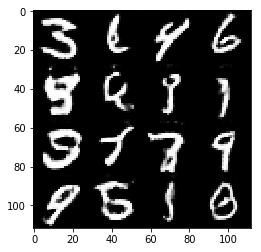

Epoch 2/2... Discriminator Loss: 1.0735... Generator Loss: 1.1340... Total Loss: 2.2075
Epoch 2/2... Discriminator Loss: 1.0578... Generator Loss: 0.9040... Total Loss: 1.9619
Epoch 2/2... Discriminator Loss: 0.6941... Generator Loss: 1.5974... Total Loss: 2.2915
Epoch 2/2... Discriminator Loss: 2.0840... Generator Loss: 0.3530... Total Loss: 2.4370
Epoch 2/2... Discriminator Loss: 1.4871... Generator Loss: 0.5209... Total Loss: 2.0080
Epoch 2/2... Discriminator Loss: 0.9685... Generator Loss: 1.0361... Total Loss: 2.0047
Epoch 2/2... Discriminator Loss: 0.7928... Generator Loss: 2.0028... Total Loss: 2.7956
Epoch 2/2... Discriminator Loss: 1.9382... Generator Loss: 0.3754... Total Loss: 2.3136
Epoch 2/2... Discriminator Loss: 1.1208... Generator Loss: 0.8124... Total Loss: 1.9331
Epoch 2/2... Discriminator Loss: 1.2038... Generator Loss: 0.7142... Total Loss: 1.9180


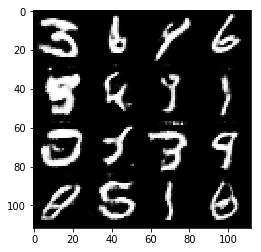

Epoch 2/2... Discriminator Loss: 0.8040... Generator Loss: 1.3313... Total Loss: 2.1352
Epoch 2/2... Discriminator Loss: 0.8451... Generator Loss: 1.2838... Total Loss: 2.1290
Epoch 2/2... Discriminator Loss: 0.9616... Generator Loss: 2.0699... Total Loss: 3.0315
Epoch 2/2... Discriminator Loss: 0.9199... Generator Loss: 1.3603... Total Loss: 2.2803
Epoch 2/2... Discriminator Loss: 0.7741... Generator Loss: 1.4382... Total Loss: 2.2123
Epoch 2/2... Discriminator Loss: 0.7935... Generator Loss: 1.3839... Total Loss: 2.1774
Epoch 2/2... Discriminator Loss: 0.8458... Generator Loss: 3.4018... Total Loss: 4.2476
Epoch 2/2... Discriminator Loss: 0.6981... Generator Loss: 2.4196... Total Loss: 3.1177
Epoch 2/2... Discriminator Loss: 0.8826... Generator Loss: 1.1480... Total Loss: 2.0307
Epoch 2/2... Discriminator Loss: 2.3847... Generator Loss: 4.1303... Total Loss: 6.5150


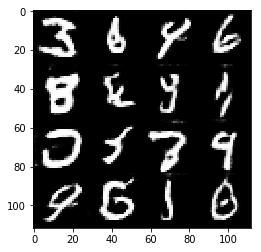

Epoch 2/2... Discriminator Loss: 0.9664... Generator Loss: 1.3245... Total Loss: 2.2909
Epoch 2/2... Discriminator Loss: 1.5376... Generator Loss: 0.5509... Total Loss: 2.0885
Epoch 2/2... Discriminator Loss: 0.7166... Generator Loss: 1.5668... Total Loss: 2.2834
Epoch 2/2... Discriminator Loss: 1.8320... Generator Loss: 0.4584... Total Loss: 2.2904
Epoch 2/2... Discriminator Loss: 1.0069... Generator Loss: 0.9635... Total Loss: 1.9704
Epoch 2/2... Discriminator Loss: 1.3064... Generator Loss: 0.6706... Total Loss: 1.9770
Epoch 2/2... Discriminator Loss: 0.8373... Generator Loss: 1.4573... Total Loss: 2.2946
Epoch 2/2... Discriminator Loss: 0.9711... Generator Loss: 1.1696... Total Loss: 2.1407
Epoch 2/2... Discriminator Loss: 1.7486... Generator Loss: 0.4346... Total Loss: 2.1832
Epoch 2/2... Discriminator Loss: 1.6996... Generator Loss: 0.3890... Total Loss: 2.0886


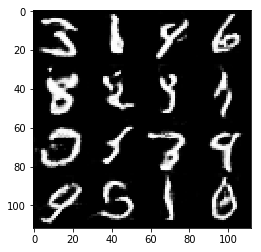

Epoch 2/2... Discriminator Loss: 0.8346... Generator Loss: 1.4365... Total Loss: 2.2710
Epoch 2/2... Discriminator Loss: 1.6949... Generator Loss: 0.3895... Total Loss: 2.0844
Epoch 2/2... Discriminator Loss: 0.7256... Generator Loss: 1.5782... Total Loss: 2.3038
Epoch 2/2... Discriminator Loss: 0.8477... Generator Loss: 1.2822... Total Loss: 2.1299
Epoch 2/2... Discriminator Loss: 0.9890... Generator Loss: 1.0843... Total Loss: 2.0732
Epoch 2/2... Discriminator Loss: 1.7589... Generator Loss: 0.3712... Total Loss: 2.1301
Epoch 2/2... Discriminator Loss: 1.2354... Generator Loss: 0.8940... Total Loss: 2.1294
Epoch 2/2... Discriminator Loss: 1.4085... Generator Loss: 3.3060... Total Loss: 4.7145
Epoch 2/2... Discriminator Loss: 1.3428... Generator Loss: 0.7755... Total Loss: 2.1183
Epoch 2/2... Discriminator Loss: 0.9233... Generator Loss: 1.1434... Total Loss: 2.0668


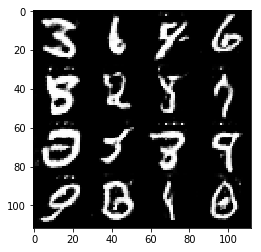

Epoch 2/2... Discriminator Loss: 1.5194... Generator Loss: 0.5628... Total Loss: 2.0822
Epoch 2/2... Discriminator Loss: 0.7369... Generator Loss: 2.4687... Total Loss: 3.2056
Epoch 2/2... Discriminator Loss: 1.3748... Generator Loss: 2.7443... Total Loss: 4.1191
Epoch 2/2... Discriminator Loss: 1.4719... Generator Loss: 0.5224... Total Loss: 1.9943
Epoch 2/2... Discriminator Loss: 1.3442... Generator Loss: 0.7289... Total Loss: 2.0731
Epoch 2/2... Discriminator Loss: 1.0941... Generator Loss: 1.0276... Total Loss: 2.1217
Epoch 2/2... Discriminator Loss: 1.1525... Generator Loss: 0.7938... Total Loss: 1.9463
Epoch 2/2... Discriminator Loss: 0.8639... Generator Loss: 1.9677... Total Loss: 2.8316
Epoch 2/2... Discriminator Loss: 0.7026... Generator Loss: 1.6979... Total Loss: 2.4005
Epoch 2/2... Discriminator Loss: 1.1452... Generator Loss: 0.8216... Total Loss: 1.9668


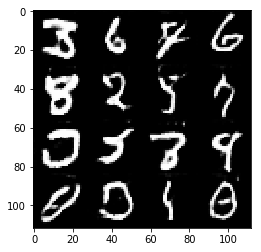

Epoch 2/2... Discriminator Loss: 0.8691... Generator Loss: 1.1564... Total Loss: 2.0256
Epoch 2/2... Discriminator Loss: 0.8279... Generator Loss: 1.2584... Total Loss: 2.0863
Epoch 2/2... Discriminator Loss: 0.9377... Generator Loss: 1.3428... Total Loss: 2.2806
Epoch 2/2... Discriminator Loss: 0.7349... Generator Loss: 2.1917... Total Loss: 2.9266
Epoch 2/2... Discriminator Loss: 2.2102... Generator Loss: 0.3069... Total Loss: 2.5171
Epoch 2/2... Discriminator Loss: 1.0307... Generator Loss: 1.3093... Total Loss: 2.3400
Epoch 2/2... Discriminator Loss: 0.7556... Generator Loss: 2.0052... Total Loss: 2.7608
Epoch 2/2... Discriminator Loss: 0.9328... Generator Loss: 1.5093... Total Loss: 2.4421
Epoch 2/2... Discriminator Loss: 1.5090... Generator Loss: 0.4730... Total Loss: 1.9819
Epoch 2/2... Discriminator Loss: 1.5894... Generator Loss: 0.5932... Total Loss: 2.1826


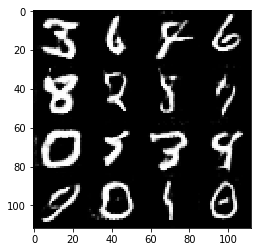

Epoch 2/2... Discriminator Loss: 0.6763... Generator Loss: 2.4791... Total Loss: 3.1554
Epoch 2/2... Discriminator Loss: 0.8286... Generator Loss: 1.3388... Total Loss: 2.1674
Epoch 2/2... Discriminator Loss: 0.7573... Generator Loss: 1.6799... Total Loss: 2.4372
Epoch 2/2... Discriminator Loss: 0.6325... Generator Loss: 1.8852... Total Loss: 2.5177
Epoch 2/2... Discriminator Loss: 1.3912... Generator Loss: 0.9177... Total Loss: 2.3089
Epoch 2/2... Discriminator Loss: 1.1227... Generator Loss: 1.3495... Total Loss: 2.4722
Epoch 2/2... Discriminator Loss: 0.8731... Generator Loss: 1.4547... Total Loss: 2.3278
Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 1.2290... Total Loss: 2.1102
Epoch 2/2... Discriminator Loss: 1.3478... Generator Loss: 0.8330... Total Loss: 2.1808
Epoch 2/2... Discriminator Loss: 0.9198... Generator Loss: 1.2137... Total Loss: 2.1335


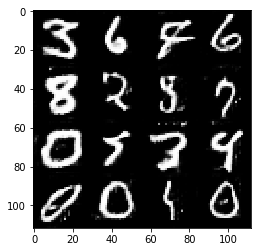

Epoch 2/2... Discriminator Loss: 1.2518... Generator Loss: 0.7349... Total Loss: 1.9866
Epoch 2/2... Discriminator Loss: 0.6203... Generator Loss: 2.3761... Total Loss: 2.9965
Epoch 2/2... Discriminator Loss: 0.8868... Generator Loss: 1.6456... Total Loss: 2.5324
Epoch 2/2... Discriminator Loss: 0.6120... Generator Loss: 2.0840... Total Loss: 2.6959
Epoch 2/2... Discriminator Loss: 0.7824... Generator Loss: 1.4101... Total Loss: 2.1925
Epoch 2/2... Discriminator Loss: 1.2842... Generator Loss: 0.6157... Total Loss: 1.8999
Epoch 2/2... Discriminator Loss: 1.8765... Generator Loss: 0.3348... Total Loss: 2.2113
Epoch 2/2... Discriminator Loss: 0.7824... Generator Loss: 1.6225... Total Loss: 2.4049
Epoch 2/2... Discriminator Loss: 0.6459... Generator Loss: 2.0675... Total Loss: 2.7134
Epoch 2/2... Discriminator Loss: 0.8974... Generator Loss: 1.1896... Total Loss: 2.0869


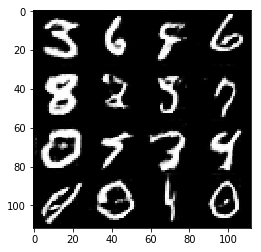

Epoch 2/2... Discriminator Loss: 1.4929... Generator Loss: 0.5380... Total Loss: 2.0309
Epoch 2/2... Discriminator Loss: 1.5013... Generator Loss: 0.5973... Total Loss: 2.0986
Epoch 2/2... Discriminator Loss: 0.8153... Generator Loss: 2.0071... Total Loss: 2.8224
Epoch 2/2... Discriminator Loss: 0.9316... Generator Loss: 1.3032... Total Loss: 2.2348
Epoch 2/2... Discriminator Loss: 0.9579... Generator Loss: 1.7853... Total Loss: 2.7433
Epoch 2/2... Discriminator Loss: 0.8591... Generator Loss: 2.4959... Total Loss: 3.3550
Epoch 2/2... Discriminator Loss: 1.9044... Generator Loss: 0.3990... Total Loss: 2.3034
Epoch 2/2... Discriminator Loss: 1.0166... Generator Loss: 1.0092... Total Loss: 2.0257
Epoch 2/2... Discriminator Loss: 1.7719... Generator Loss: 0.4878... Total Loss: 2.2597
Epoch 2/2... Discriminator Loss: 1.2756... Generator Loss: 3.2973... Total Loss: 4.5730


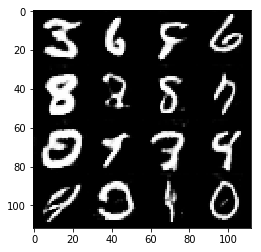

Epoch 2/2... Discriminator Loss: 1.1554... Generator Loss: 0.9216... Total Loss: 2.0769
Epoch 2/2... Discriminator Loss: 0.9188... Generator Loss: 1.1529... Total Loss: 2.0716
Epoch 2/2... Discriminator Loss: 1.6499... Generator Loss: 4.4295... Total Loss: 6.0794
Epoch 2/2... Discriminator Loss: 1.4991... Generator Loss: 0.6212... Total Loss: 2.1204
Epoch 2/2... Discriminator Loss: 0.8545... Generator Loss: 1.3994... Total Loss: 2.2539
Epoch 2/2... Discriminator Loss: 0.8949... Generator Loss: 1.3817... Total Loss: 2.2766
Epoch 2/2... Discriminator Loss: 1.1020... Generator Loss: 0.8292... Total Loss: 1.9311
Epoch 2/2... Discriminator Loss: 0.9365... Generator Loss: 1.1347... Total Loss: 2.0712
Epoch 2/2... Discriminator Loss: 1.3471... Generator Loss: 0.6204... Total Loss: 1.9675
Epoch 2/2... Discriminator Loss: 1.1089... Generator Loss: 1.9213... Total Loss: 3.0301


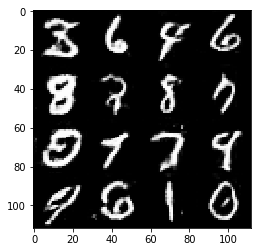

Epoch 2/2... Discriminator Loss: 1.0459... Generator Loss: 3.5523... Total Loss: 4.5983
Epoch 2/2... Discriminator Loss: 0.6102... Generator Loss: 1.8752... Total Loss: 2.4855
Epoch 2/2... Discriminator Loss: 1.9076... Generator Loss: 0.5705... Total Loss: 2.4781
Epoch 2/2... Discriminator Loss: 1.1408... Generator Loss: 1.0511... Total Loss: 2.1919
Epoch 2/2... Discriminator Loss: 0.9525... Generator Loss: 1.5967... Total Loss: 2.5492
Epoch 2/2... Discriminator Loss: 0.8878... Generator Loss: 1.1538... Total Loss: 2.0416
Epoch 2/2... Discriminator Loss: 0.8712... Generator Loss: 1.9923... Total Loss: 2.8634
Epoch 2/2... Discriminator Loss: 1.0462... Generator Loss: 1.1343... Total Loss: 2.1805
Epoch 2/2... Discriminator Loss: 0.6758... Generator Loss: 1.7841... Total Loss: 2.4598
Epoch 2/2... Discriminator Loss: 0.9783... Generator Loss: 1.0470... Total Loss: 2.0253


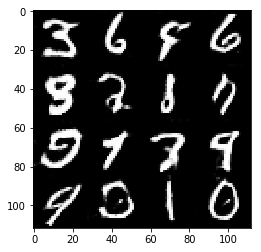

Epoch 2/2... Discriminator Loss: 1.4550... Generator Loss: 0.5084... Total Loss: 1.9634
Epoch 2/2... Discriminator Loss: 1.4078... Generator Loss: 0.7230... Total Loss: 2.1308
Epoch 2/2... Discriminator Loss: 0.6231... Generator Loss: 1.8684... Total Loss: 2.4915
Epoch 2/2... Discriminator Loss: 0.9469... Generator Loss: 1.0984... Total Loss: 2.0453
Epoch 2/2... Discriminator Loss: 0.9449... Generator Loss: 1.2020... Total Loss: 2.1469
Epoch 2/2... Discriminator Loss: 1.3543... Generator Loss: 0.8247... Total Loss: 2.1791
Epoch 2/2... Discriminator Loss: 0.9019... Generator Loss: 1.9922... Total Loss: 2.8941
Epoch 2/2... Discriminator Loss: 0.8052... Generator Loss: 1.6077... Total Loss: 2.4129
Epoch 2/2... Discriminator Loss: 1.1737... Generator Loss: 0.8295... Total Loss: 2.0033
Epoch 2/2... Discriminator Loss: 0.8434... Generator Loss: 1.5254... Total Loss: 2.3688


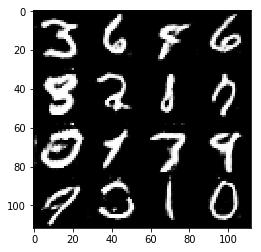

Epoch 2/2... Discriminator Loss: 0.8172... Generator Loss: 1.5912... Total Loss: 2.4084
Epoch 2/2... Discriminator Loss: 0.9433... Generator Loss: 1.9905... Total Loss: 2.9338
Epoch 2/2... Discriminator Loss: 1.2275... Generator Loss: 0.7565... Total Loss: 1.9839
Epoch 2/2... Discriminator Loss: 0.8740... Generator Loss: 2.5839... Total Loss: 3.4580
Epoch 2/2... Discriminator Loss: 0.6498... Generator Loss: 1.9511... Total Loss: 2.6009
Epoch 2/2... Discriminator Loss: 1.6641... Generator Loss: 3.3981... Total Loss: 5.0622
Epoch 2/2... Discriminator Loss: 2.2214... Generator Loss: 0.3115... Total Loss: 2.5329
Epoch 2/2... Discriminator Loss: 1.1900... Generator Loss: 0.8437... Total Loss: 2.0337
Epoch 2/2... Discriminator Loss: 1.5312... Generator Loss: 0.6210... Total Loss: 2.1522
Epoch 2/2... Discriminator Loss: 0.6496... Generator Loss: 2.5987... Total Loss: 3.2484


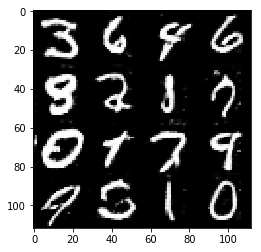

Epoch 2/2... Discriminator Loss: 0.9883... Generator Loss: 1.2038... Total Loss: 2.1921
Epoch 2/2... Discriminator Loss: 0.7238... Generator Loss: 1.5113... Total Loss: 2.2352
Epoch 2/2... Discriminator Loss: 0.6459... Generator Loss: 1.8767... Total Loss: 2.5226
Epoch 2/2... Discriminator Loss: 0.6100... Generator Loss: 1.8237... Total Loss: 2.4337
Epoch 2/2... Discriminator Loss: 1.3055... Generator Loss: 0.8124... Total Loss: 2.1179
Epoch 2/2... Discriminator Loss: 1.2899... Generator Loss: 0.8740... Total Loss: 2.1639
Epoch 2/2... Discriminator Loss: 0.7331... Generator Loss: 1.4309... Total Loss: 2.1640
Epoch 2/2... Discriminator Loss: 1.0632... Generator Loss: 0.8746... Total Loss: 1.9378
Epoch 2/2... Discriminator Loss: 0.7407... Generator Loss: 1.6823... Total Loss: 2.4230
Epoch 2/2... Discriminator Loss: 0.5803... Generator Loss: 2.2857... Total Loss: 2.8660


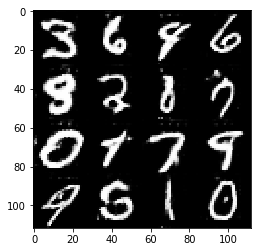

Epoch 2/2... Discriminator Loss: 1.2505... Generator Loss: 3.5902... Total Loss: 4.8407
Epoch 2/2... Discriminator Loss: 0.8745... Generator Loss: 1.2872... Total Loss: 2.1618
Epoch 2/2... Discriminator Loss: 1.1326... Generator Loss: 0.8324... Total Loss: 1.9650
Epoch 2/2... Discriminator Loss: 1.3753... Generator Loss: 0.6484... Total Loss: 2.0237
Epoch 2/2... Discriminator Loss: 1.3077... Generator Loss: 1.2943... Total Loss: 2.6021
Training finished.


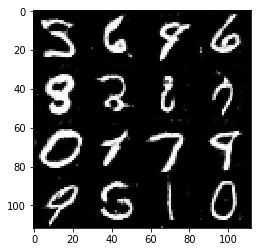

In [14]:
batch_size = 32
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.9700... Generator Loss: 31.2293... Total Loss: 33.1994
Epoch 1/1... Discriminator Loss: 0.6450... Generator Loss: 2.7105... Total Loss: 3.3555
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.9100... Total Loss: 2.2885
Epoch 1/1... Discriminator Loss: 0.8619... Generator Loss: 1.6283... Total Loss: 2.4902
Epoch 1/1... Discriminator Loss: 1.9275... Generator Loss: 0.6308... Total Loss: 2.5582
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 1.2277... Total Loss: 2.1747
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 5.2152... Total Loss: 6.0967
Epoch 1/1... Discriminator Loss: 0.5223... Generator Loss: 3.6024... Total Loss: 4.1246
Epoch 1/1... Discriminator Loss: 0.7926... Generator Loss: 5.9300... Total Loss: 6.7226
Epoch 1/1... Discriminator Loss: 0.6752... Generator Loss: 3.0531... Total Loss: 3.7283


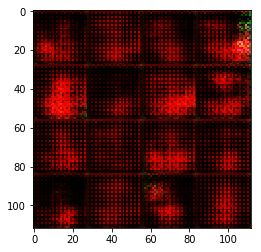

Epoch 1/1... Discriminator Loss: 0.6604... Generator Loss: 2.1080... Total Loss: 2.7683
Epoch 1/1... Discriminator Loss: 0.4912... Generator Loss: 4.2197... Total Loss: 4.7110
Epoch 1/1... Discriminator Loss: 4.6867... Generator Loss: 10.0006... Total Loss: 14.6873
Epoch 1/1... Discriminator Loss: 3.0900... Generator Loss: 5.9696... Total Loss: 9.0596
Epoch 1/1... Discriminator Loss: 2.3772... Generator Loss: 4.8518... Total Loss: 7.2290
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 1.0636... Total Loss: 2.5399
Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 1.3469... Total Loss: 2.2725
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 1.8766... Total Loss: 3.2588
Epoch 1/1... Discriminator Loss: 2.1521... Generator Loss: 0.3180... Total Loss: 2.4701
Epoch 1/1... Discriminator Loss: 1.5779... Generator Loss: 1.0222... Total Loss: 2.6001


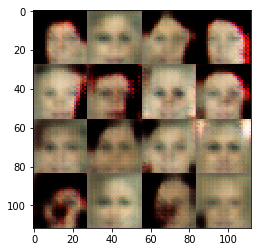

Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.5279... Total Loss: 2.0152
Epoch 1/1... Discriminator Loss: 1.5494... Generator Loss: 1.6431... Total Loss: 3.1924
Epoch 1/1... Discriminator Loss: 1.7465... Generator Loss: 1.3302... Total Loss: 3.0766
Epoch 1/1... Discriminator Loss: 1.7224... Generator Loss: 1.5783... Total Loss: 3.3007
Epoch 1/1... Discriminator Loss: 1.5523... Generator Loss: 0.4929... Total Loss: 2.0452
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.8395... Total Loss: 2.2000
Epoch 1/1... Discriminator Loss: 1.5293... Generator Loss: 2.4351... Total Loss: 3.9644
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 1.2953... Total Loss: 2.5438
Epoch 1/1... Discriminator Loss: 1.8863... Generator Loss: 0.3652... Total Loss: 2.2516
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.5970... Total Loss: 1.8472


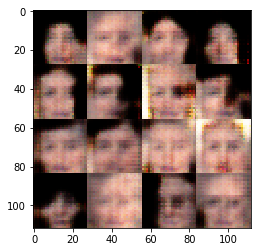

Epoch 1/1... Discriminator Loss: 2.8671... Generator Loss: 0.1319... Total Loss: 2.9990
Epoch 1/1... Discriminator Loss: 1.7105... Generator Loss: 0.5555... Total Loss: 2.2660
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.9401... Total Loss: 2.0327
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 1.1255... Total Loss: 2.1416
Epoch 1/1... Discriminator Loss: 1.6365... Generator Loss: 0.3726... Total Loss: 2.0091
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 0.8522... Total Loss: 1.9343
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 1.0808... Total Loss: 2.4641
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 1.4851... Total Loss: 2.7197
Epoch 1/1... Discriminator Loss: 1.7998... Generator Loss: 0.3708... Total Loss: 2.1706
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.7237... Total Loss: 1.9301


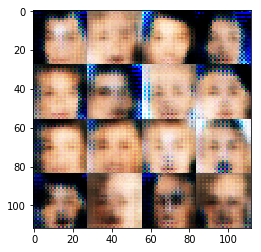

Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 1.5741... Total Loss: 2.9222
Epoch 1/1... Discriminator Loss: 1.6069... Generator Loss: 1.6085... Total Loss: 3.2154
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.8857... Total Loss: 2.1282
Epoch 1/1... Discriminator Loss: 1.8491... Generator Loss: 2.4405... Total Loss: 4.2896
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 1.0136... Total Loss: 2.1830
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 1.4379... Total Loss: 2.7016
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.8171... Total Loss: 2.2390
Epoch 1/1... Discriminator Loss: 1.6654... Generator Loss: 2.6588... Total Loss: 4.3242
Epoch 1/1... Discriminator Loss: 2.2543... Generator Loss: 2.6096... Total Loss: 4.8639
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.6198... Total Loss: 1.8997


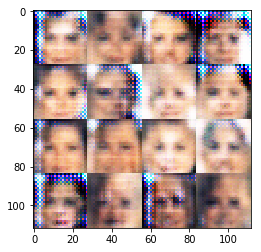

Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 1.6694... Total Loss: 2.7774
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 1.1757... Total Loss: 2.2007
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.8445... Total Loss: 2.0033
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 1.3303... Total Loss: 2.4282
Epoch 1/1... Discriminator Loss: 1.6737... Generator Loss: 2.5544... Total Loss: 4.2281
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 1.1571... Total Loss: 2.3569
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7833... Total Loss: 2.2146
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 1.2958... Total Loss: 2.4013
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 1.2429... Total Loss: 2.7354
Epoch 1/1... Discriminator Loss: 1.7363... Generator Loss: 0.3845... Total Loss: 2.1208


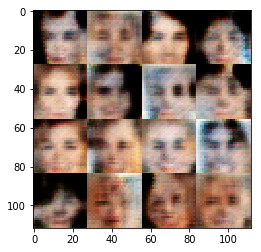

Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7728... Total Loss: 2.1785
Epoch 1/1... Discriminator Loss: 2.0288... Generator Loss: 2.5628... Total Loss: 4.5916
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 1.2025... Total Loss: 2.3140
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.8123... Total Loss: 2.0673
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.8166... Total Loss: 2.0415
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 1.2987... Total Loss: 2.7775
Epoch 1/1... Discriminator Loss: 1.8165... Generator Loss: 0.5891... Total Loss: 2.4056
Epoch 1/1... Discriminator Loss: 1.6956... Generator Loss: 0.3508... Total Loss: 2.0464
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 1.2542... Total Loss: 2.6125
Epoch 1/1... Discriminator Loss: 1.5935... Generator Loss: 1.4745... Total Loss: 3.0680


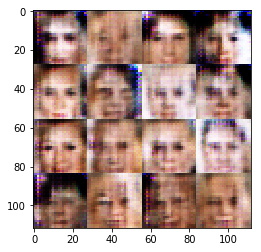

Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.6408... Total Loss: 1.9719
Epoch 1/1... Discriminator Loss: 1.7280... Generator Loss: 0.3883... Total Loss: 2.1163
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 1.0563... Total Loss: 2.3259
Epoch 1/1... Discriminator Loss: 2.0362... Generator Loss: 0.6215... Total Loss: 2.6577
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.9010... Total Loss: 2.1247
Epoch 1/1... Discriminator Loss: 1.5402... Generator Loss: 0.5383... Total Loss: 2.0785
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.9842... Total Loss: 2.1875
Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 0.4854... Total Loss: 2.0038
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 1.0740... Total Loss: 2.3705
Epoch 1/1... Discriminator Loss: 1.7337... Generator Loss: 0.5610... Total Loss: 2.2946


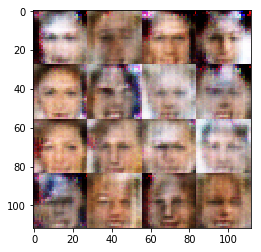

Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 1.0803... Total Loss: 2.3910
Epoch 1/1... Discriminator Loss: 1.5750... Generator Loss: 0.4405... Total Loss: 2.0155
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7279... Total Loss: 2.1233
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 1.2893... Total Loss: 2.7135
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.7683... Total Loss: 2.2309
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 1.5994... Total Loss: 2.8796
Epoch 1/1... Discriminator Loss: 2.1648... Generator Loss: 2.2933... Total Loss: 4.4581
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.7587... Total Loss: 1.8978
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.7285... Total Loss: 2.2417
Epoch 1/1... Discriminator Loss: 1.9019... Generator Loss: 1.8867... Total Loss: 3.7886


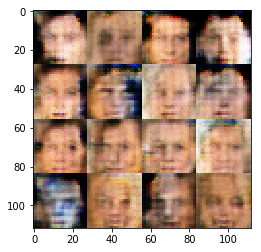

Epoch 1/1... Discriminator Loss: 1.9200... Generator Loss: 2.3973... Total Loss: 4.3173
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.8911... Total Loss: 2.2455
Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 1.3119... Total Loss: 2.2472
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6928... Total Loss: 2.0891
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7079... Total Loss: 2.0866
Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 1.5357... Total Loss: 3.0172
Epoch 1/1... Discriminator Loss: 1.6495... Generator Loss: 0.5072... Total Loss: 2.1568
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 2.1318... Total Loss: 3.6106
Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 0.9197... Total Loss: 1.9875
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.5823... Total Loss: 1.9594


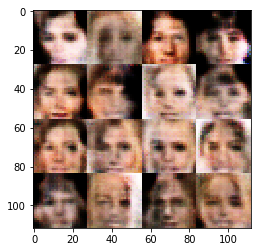

Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.9723... Total Loss: 2.1938
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.8993... Total Loss: 2.3852
Epoch 1/1... Discriminator Loss: 1.0292... Generator Loss: 1.0833... Total Loss: 2.1125
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 1.2127... Total Loss: 2.6380
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.6967... Total Loss: 2.0878
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.8162... Total Loss: 2.1944
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.9633... Total Loss: 2.1509
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.9050... Total Loss: 2.0951
Epoch 1/1... Discriminator Loss: 1.6581... Generator Loss: 0.4025... Total Loss: 2.0606
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 1.0066... Total Loss: 2.4020


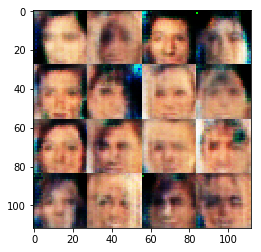

Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 1.2341... Total Loss: 2.3652
Epoch 1/1... Discriminator Loss: 2.6171... Generator Loss: 3.4041... Total Loss: 6.0211
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.6838... Total Loss: 2.1378
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7897... Total Loss: 2.1772
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6164... Total Loss: 2.0189
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.6317... Total Loss: 1.9744
Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 0.9984... Total Loss: 2.5162
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.8573... Total Loss: 2.0307
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.9930... Total Loss: 2.1979
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.6735... Total Loss: 2.0171


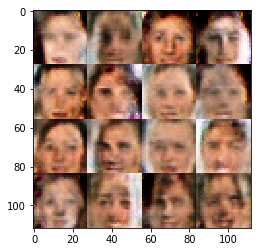

Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.7138... Total Loss: 2.0726
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.7628... Total Loss: 2.1004
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.8787... Total Loss: 2.3293
Epoch 1/1... Discriminator Loss: 1.6898... Generator Loss: 0.7045... Total Loss: 2.3943
Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 0.7319... Total Loss: 2.2373
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.8732... Total Loss: 2.1539
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.6739... Total Loss: 1.9036
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 1.0082... Total Loss: 2.2638
Epoch 1/1... Discriminator Loss: 1.5841... Generator Loss: 0.9525... Total Loss: 2.5366
Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 0.6320... Total Loss: 2.1560


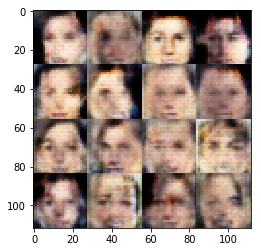

Epoch 1/1... Discriminator Loss: 1.7254... Generator Loss: 0.5300... Total Loss: 2.2554
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.7494... Total Loss: 2.1919
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.8537... Total Loss: 2.2069
Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.6733... Total Loss: 2.1790
Epoch 1/1... Discriminator Loss: 1.5429... Generator Loss: 0.6205... Total Loss: 2.1634
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7394... Total Loss: 2.1504
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.9533... Total Loss: 2.3553
Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.6379... Total Loss: 2.1348
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.9069... Total Loss: 2.2307
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.7826... Total Loss: 2.1426


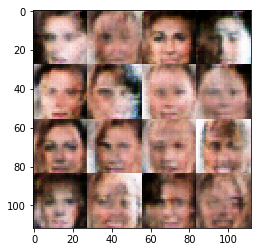

Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.7917... Total Loss: 2.1608
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.8026... Total Loss: 2.0525
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.9038... Total Loss: 2.2972
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.8192... Total Loss: 2.2013
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7710... Total Loss: 2.1613
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6864... Total Loss: 2.0748
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 1.3288... Total Loss: 2.5799
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.7199... Total Loss: 2.0255
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.9555... Total Loss: 2.4189
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 1.2616... Total Loss: 2.2567


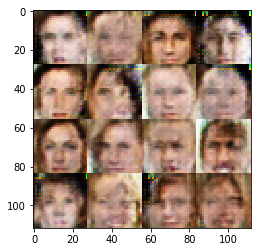

Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 1.0742... Total Loss: 2.2357
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.9910... Total Loss: 2.2803
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.8513... Total Loss: 2.2247
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.7443... Total Loss: 2.0881
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.8754... Total Loss: 2.3635
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.9461... Total Loss: 2.1885
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 1.1472... Total Loss: 2.4866
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.7477... Total Loss: 2.0907
Epoch 1/1... Discriminator Loss: 1.6367... Generator Loss: 1.0747... Total Loss: 2.7114
Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 1.0628... Total Loss: 2.5569


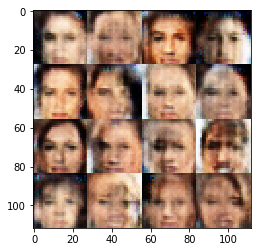

Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.6861... Total Loss: 2.0643
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.9246... Total Loss: 2.0865
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.6568... Total Loss: 2.0864
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.9257... Total Loss: 2.1732
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 1.0602... Total Loss: 2.2916
Epoch 1/1... Discriminator Loss: 0.7433... Generator Loss: 1.4126... Total Loss: 2.1559
Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 0.9939... Total Loss: 2.0843
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 1.1160... Total Loss: 2.4947
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.7029... Total Loss: 2.0543
Epoch 1/1... Discriminator Loss: 1.6715... Generator Loss: 1.0512... Total Loss: 2.7227


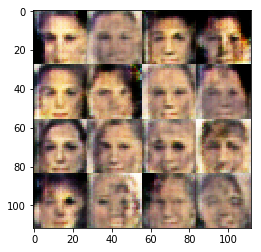

Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 1.0413... Total Loss: 2.3368
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.5565... Total Loss: 1.9988
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.8523... Total Loss: 2.1643
Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.6924... Total Loss: 2.2029
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 1.0186... Total Loss: 2.1671
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.8044... Total Loss: 2.2291
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.8189... Total Loss: 2.0961
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.7011... Total Loss: 1.9854
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.6381... Total Loss: 1.9579
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.5816... Total Loss: 2.0266


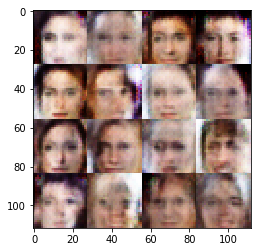

Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.7848... Total Loss: 2.0361
Epoch 1/1... Discriminator Loss: 1.6070... Generator Loss: 1.0362... Total Loss: 2.6433
Epoch 1/1... Discriminator Loss: 1.6626... Generator Loss: 0.4912... Total Loss: 2.1538
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7564... Total Loss: 2.1672
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.7750... Total Loss: 2.1182
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 1.0343... Total Loss: 2.2074
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.8041... Total Loss: 2.1909
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.9909... Total Loss: 2.3239
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.6602... Total Loss: 2.0504
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7201... Total Loss: 2.1141


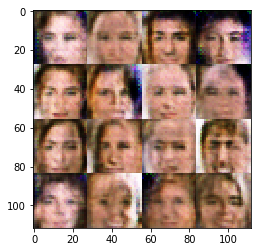

Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.9909... Total Loss: 2.3099
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.7572... Total Loss: 2.1111
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.9360... Total Loss: 2.2448
Epoch 1/1... Discriminator Loss: 1.5412... Generator Loss: 0.4653... Total Loss: 2.0065
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.8794... Total Loss: 2.1126
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.7866... Total Loss: 2.0536
Epoch 1/1... Discriminator Loss: 1.6836... Generator Loss: 0.3791... Total Loss: 2.0627
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.7301... Total Loss: 2.1792
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.6661... Total Loss: 2.0100
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.7399... Total Loss: 2.0624


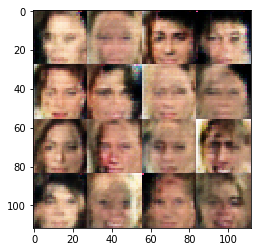

Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.8902... Total Loss: 2.2062
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 1.1037... Total Loss: 2.4636
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.7828... Total Loss: 2.1327
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.7710... Total Loss: 2.1009
Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 0.8297... Total Loss: 1.9029
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.6592... Total Loss: 1.9822
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.7493... Total Loss: 2.0310
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.9042... Total Loss: 2.4011
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.8286... Total Loss: 2.1914
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 1.0800... Total Loss: 2.5252


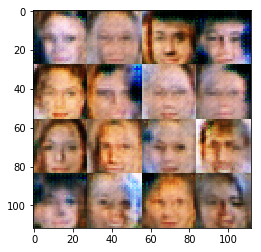

Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 1.0726... Total Loss: 2.5147
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.8418... Total Loss: 2.2434
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.9414... Total Loss: 2.1888
Epoch 1/1... Discriminator Loss: 1.5404... Generator Loss: 0.7564... Total Loss: 2.2969
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7506... Total Loss: 2.1360
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7118... Total Loss: 2.1040
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.8848... Total Loss: 2.1495
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.8451... Total Loss: 2.2671
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.8488... Total Loss: 2.2621
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.6147... Total Loss: 1.9785


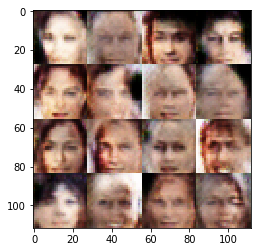

Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.7157... Total Loss: 2.1814
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.6488... Total Loss: 2.0322
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.9544... Total Loss: 2.2919
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.7049... Total Loss: 2.1763
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.9266... Total Loss: 2.2338
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.8516... Total Loss: 2.3152
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.8256... Total Loss: 2.2056
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.6808... Total Loss: 2.0881
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.8532... Total Loss: 2.0769
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.8538... Total Loss: 2.2089


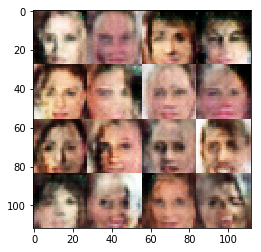

Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.7202... Total Loss: 2.0365
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.8016... Total Loss: 2.0899
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7103... Total Loss: 2.1144
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.8166... Total Loss: 2.2638
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.8168... Total Loss: 2.0833
Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.7378... Total Loss: 2.2607
Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.9342... Total Loss: 2.4307
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.9285... Total Loss: 2.2376
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.6564... Total Loss: 2.1445
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.8218... Total Loss: 2.2143


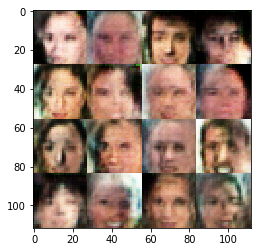

Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.6813... Total Loss: 2.0816
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.9714... Total Loss: 2.2073
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.7969... Total Loss: 2.0361
Epoch 1/1... Discriminator Loss: 1.5335... Generator Loss: 0.4613... Total Loss: 1.9948
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.8102... Total Loss: 2.1843
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.7518... Total Loss: 2.1981
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.4361... Total Loss: 1.9674
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 1.3819... Total Loss: 2.9053
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.9168... Total Loss: 2.3181
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.7654... Total Loss: 2.0749


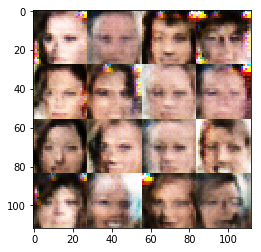

Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.6525... Total Loss: 2.0332
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.8134... Total Loss: 2.3294
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.7901... Total Loss: 2.2319
Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.6305... Total Loss: 2.1575
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.8125... Total Loss: 2.1786
Epoch 1/1... Discriminator Loss: 1.5586... Generator Loss: 0.6849... Total Loss: 2.2435
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.6877... Total Loss: 2.0356
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.5479... Total Loss: 2.0352
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.9023... Total Loss: 2.3254
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.8691... Total Loss: 2.1168


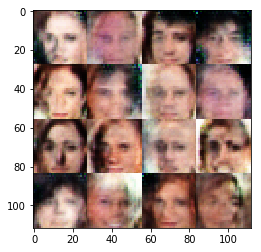

Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.5789... Total Loss: 2.0238
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.8295... Total Loss: 2.1156
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.8066... Total Loss: 2.0705
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.7058... Total Loss: 2.2042
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.7155... Total Loss: 2.0569
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.8962... Total Loss: 2.2084
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.8569... Total Loss: 2.3212
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.8154... Total Loss: 2.1419
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.7389... Total Loss: 2.0591
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 1.0126... Total Loss: 2.3401


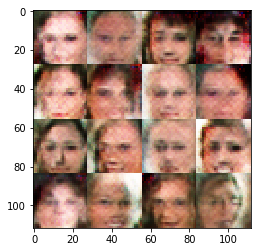

Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7719... Total Loss: 2.1475
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.7363... Total Loss: 2.0709
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.7614... Total Loss: 2.0720
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.8112... Total Loss: 2.1467
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.8383... Total Loss: 2.2149
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.9260... Total Loss: 2.2610
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.7834... Total Loss: 2.1333
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.7181... Total Loss: 2.0767
Epoch 1/1... Discriminator Loss: 1.6047... Generator Loss: 0.9754... Total Loss: 2.5801
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.8512... Total Loss: 2.1850


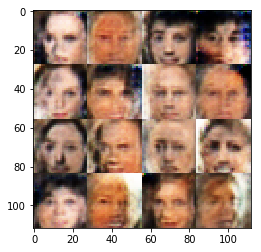

Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.9454... Total Loss: 2.2943
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.6434... Total Loss: 2.1455
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.8902... Total Loss: 2.2214
Epoch 1/1... Discriminator Loss: 1.5855... Generator Loss: 1.0982... Total Loss: 2.6837
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.8368... Total Loss: 2.1723
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7607... Total Loss: 2.1335
Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 0.7730... Total Loss: 2.2533
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.8059... Total Loss: 2.1243
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.8121... Total Loss: 2.0488
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 0.8144... Total Loss: 1.9494


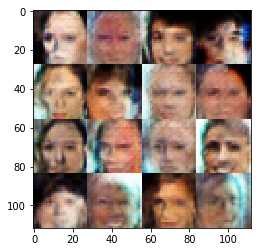

Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.9892... Total Loss: 2.2539
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7482... Total Loss: 2.1268
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.7017... Total Loss: 1.8759
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.8141... Total Loss: 2.2177
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.5906... Total Loss: 2.0547
Epoch 1/1... Discriminator Loss: 1.7284... Generator Loss: 0.6922... Total Loss: 2.4206
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.7502... Total Loss: 2.2659
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.8417... Total Loss: 2.2420
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.8376... Total Loss: 2.2704
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.8041... Total Loss: 2.2119


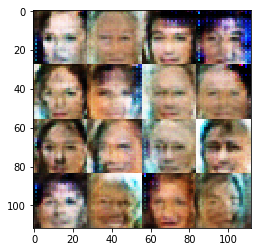

Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7241... Total Loss: 2.1277
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.8085... Total Loss: 2.1596
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.7372... Total Loss: 2.2031
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7239... Total Loss: 2.1221
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.8522... Total Loss: 2.2001
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7974... Total Loss: 2.2236
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.8173... Total Loss: 2.0735
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.9651... Total Loss: 2.3658
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.8049... Total Loss: 2.1879
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.9630... Total Loss: 2.3381


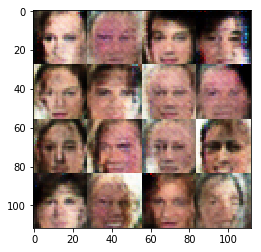

Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.7300... Total Loss: 2.0634
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7724... Total Loss: 2.1640
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.8330... Total Loss: 2.2086
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.7541... Total Loss: 2.1157
Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.6550... Total Loss: 2.1882
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.6174... Total Loss: 2.0854
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.9073... Total Loss: 2.2518
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.8772... Total Loss: 2.2323
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7666... Total Loss: 2.1939
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.7624... Total Loss: 2.1135


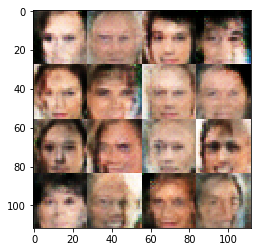

Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.7643... Total Loss: 2.2961
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.8560... Total Loss: 2.2152
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7173... Total Loss: 2.1580
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.7519... Total Loss: 2.1156
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.9212... Total Loss: 2.1637
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.8179... Total Loss: 2.1165
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.6864... Total Loss: 2.1096
Epoch 1/1... Discriminator Loss: 1.5335... Generator Loss: 0.7846... Total Loss: 2.3181
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.6685... Total Loss: 2.0187
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.7355... Total Loss: 2.0937


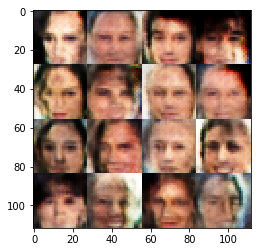

Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.8386... Total Loss: 2.2455
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.7435... Total Loss: 2.0863
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.8098... Total Loss: 2.2080
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.8783... Total Loss: 2.3758
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.8449... Total Loss: 2.1821
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.8525... Total Loss: 2.2463
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.8794... Total Loss: 2.2347
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.8097... Total Loss: 2.2274
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.9529... Total Loss: 2.3840
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.9668... Total Loss: 2.3106


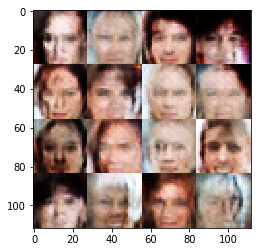

Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7502... Total Loss: 2.1516
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.7179... Total Loss: 2.0179
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.7579... Total Loss: 2.1250
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.8797... Total Loss: 2.3031
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6687... Total Loss: 2.0757
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.8325... Total Loss: 2.2429
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.7574... Total Loss: 2.0976
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.8065... Total Loss: 2.1960
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.8006... Total Loss: 2.2164
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7917... Total Loss: 2.1627


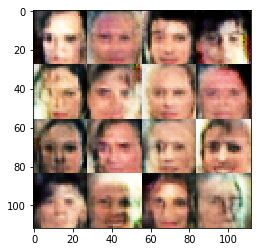

Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.8568... Total Loss: 2.1333
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6557... Total Loss: 2.0412
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7713... Total Loss: 2.1982
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.8973... Total Loss: 2.1759
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.7790... Total Loss: 2.0736
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.8316... Total Loss: 2.1807
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.9591... Total Loss: 2.2378
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.7419... Total Loss: 2.2430
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.8958... Total Loss: 2.1392
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7750... Total Loss: 2.1515


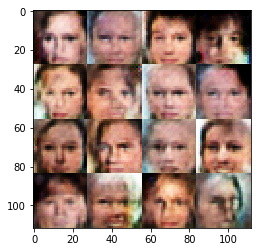

Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.6524... Total Loss: 1.9871
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.8036... Total Loss: 2.1096
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7627... Total Loss: 2.1668
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.8019... Total Loss: 2.0856
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.8680... Total Loss: 2.2622
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6944... Total Loss: 2.0839
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.7954... Total Loss: 2.0847
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.7252... Total Loss: 2.1687
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.8326... Total Loss: 2.1982
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.8727... Total Loss: 2.2438


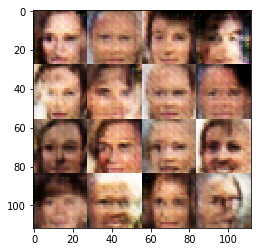

Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7356... Total Loss: 2.1247
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.8380... Total Loss: 2.3113
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.8104... Total Loss: 2.1865
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6872... Total Loss: 2.0912
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.7737... Total Loss: 2.0601
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.7167... Total Loss: 2.1536
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7418... Total Loss: 2.1814
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.6934... Total Loss: 2.0487
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.7458... Total Loss: 2.2311
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7496... Total Loss: 2.1131


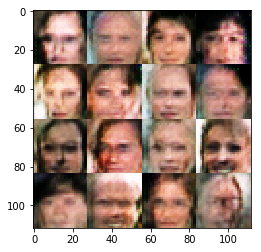

Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.7658... Total Loss: 2.0482
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.9439... Total Loss: 2.3079
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.6896... Total Loss: 2.1185
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.8173... Total Loss: 2.1368
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7965... Total Loss: 2.2012
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.8188... Total Loss: 2.0947
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.7263... Total Loss: 2.0775
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.9697... Total Loss: 2.3083
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7838... Total Loss: 2.2083
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.8359... Total Loss: 2.1734


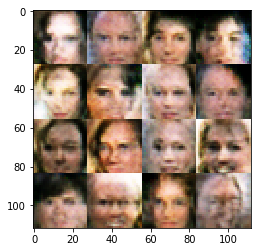

Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.9490... Total Loss: 2.2103
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.7294... Total Loss: 2.1966
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.8084... Total Loss: 2.1466
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7302... Total Loss: 2.1265
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.9258... Total Loss: 2.3451
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.9398... Total Loss: 2.3003
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.9029... Total Loss: 2.2679
Epoch 1/1... Discriminator Loss: 1.6152... Generator Loss: 0.5959... Total Loss: 2.2112
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.7595... Total Loss: 2.1866
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.8364... Total Loss: 2.1137


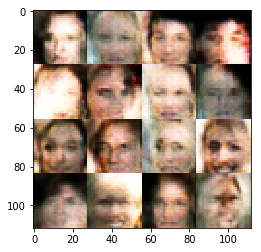

Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.7053... Total Loss: 2.1287
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.8872... Total Loss: 2.1950
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.9062... Total Loss: 2.1977
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.8960... Total Loss: 2.4016
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.7986... Total Loss: 2.1262
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.8898... Total Loss: 2.1975
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.8928... Total Loss: 2.3215
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7428... Total Loss: 2.1406
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.8336... Total Loss: 2.2071
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.7215... Total Loss: 2.0174


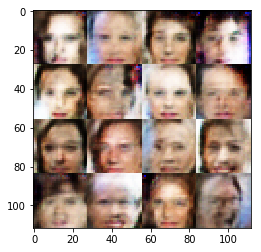

Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.8545... Total Loss: 2.1504
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7031... Total Loss: 2.0959
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.8823... Total Loss: 2.1563
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.9452... Total Loss: 2.2187
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.6987... Total Loss: 2.0478
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.7122... Total Loss: 2.0095
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.6860... Total Loss: 2.0632
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.9439... Total Loss: 2.2215
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.8008... Total Loss: 2.2438
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7955... Total Loss: 2.1797


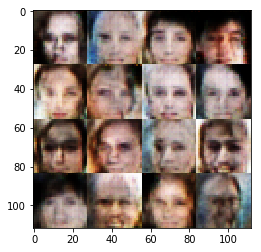

Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.7280... Total Loss: 2.0326
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.9037... Total Loss: 2.2067
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.7901... Total Loss: 2.1100
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.8287... Total Loss: 2.1825
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.7752... Total Loss: 2.2078
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7432... Total Loss: 2.1390
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.8585... Total Loss: 2.3564
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7293... Total Loss: 2.1443
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.8398... Total Loss: 2.1851
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.8449... Total Loss: 2.2181


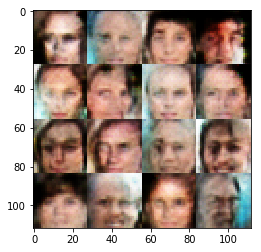

Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.8365... Total Loss: 2.1242
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.8606... Total Loss: 2.1815
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.8596... Total Loss: 2.1498
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.6525... Total Loss: 2.0413
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.8504... Total Loss: 2.0987
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.8543... Total Loss: 2.1761
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6930... Total Loss: 2.0863
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.8077... Total Loss: 2.1960
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.8113... Total Loss: 2.2688
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.9058... Total Loss: 2.2779


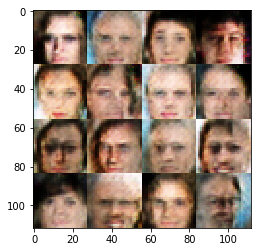

Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.7413... Total Loss: 2.0722
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.8058... Total Loss: 2.1904
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7528... Total Loss: 2.1451
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7426... Total Loss: 2.1666
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.8244... Total Loss: 2.1584
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.7850... Total Loss: 2.0893
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.7155... Total Loss: 2.1445
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.7106... Total Loss: 2.0046
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.8840... Total Loss: 2.2275
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.8430... Total Loss: 2.2584


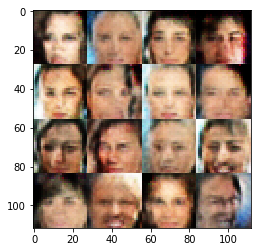

Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.8510... Total Loss: 2.2227
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.7960... Total Loss: 2.1014
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7987... Total Loss: 2.1961
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.7779... Total Loss: 2.0254
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.8878... Total Loss: 2.2183
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7202... Total Loss: 2.0995
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.8880... Total Loss: 2.1838
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.7397... Total Loss: 2.0735
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.8633... Total Loss: 2.1058
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.8454... Total Loss: 2.2112


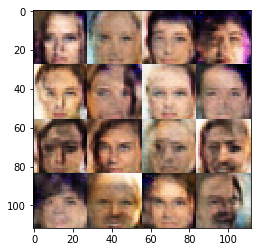

Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.7170... Total Loss: 2.0781
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7020... Total Loss: 2.1158
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.6778... Total Loss: 2.1692
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.7906... Total Loss: 2.2381
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.8578... Total Loss: 2.1885
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.6973... Total Loss: 2.0971
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.7843... Total Loss: 2.1583
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.8662... Total Loss: 2.2318
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.7743... Total Loss: 2.2100
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.7100... Total Loss: 2.1663


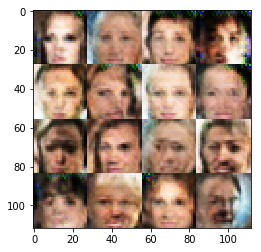

Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7497... Total Loss: 2.1544
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.7427... Total Loss: 2.1707
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.8435... Total Loss: 2.1681
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.8545... Total Loss: 2.2311
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.7886... Total Loss: 2.0684
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.8461... Total Loss: 2.3058
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.8076... Total Loss: 2.2045
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7734... Total Loss: 2.1561
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.7305... Total Loss: 2.0760
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.8485... Total Loss: 2.2170


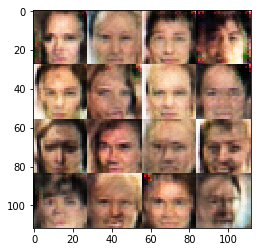

Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.5610... Total Loss: 1.9856
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.8040... Total Loss: 2.1660
Epoch 1/1... Discriminator Loss: 1.6707... Generator Loss: 0.6175... Total Loss: 2.2882
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7063... Total Loss: 2.1283
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.8102... Total Loss: 2.2294
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.7732... Total Loss: 2.1259
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.8376... Total Loss: 2.2077
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.7952... Total Loss: 2.1485
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.8344... Total Loss: 2.2088
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.8059... Total Loss: 2.0682


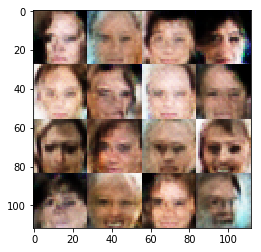

Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.7261... Total Loss: 2.0799
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.7216... Total Loss: 2.1712
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7054... Total Loss: 2.0820
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.7976... Total Loss: 2.1548
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7768... Total Loss: 2.1743
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.8957... Total Loss: 2.2086
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.8165... Total Loss: 2.1975
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.7160... Total Loss: 2.0652
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.7695... Total Loss: 2.2228
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7946... Total Loss: 2.1747


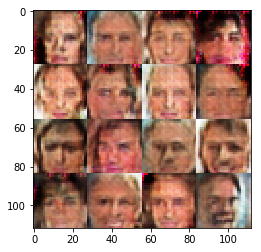

Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.7274... Total Loss: 2.2027
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.6803... Total Loss: 2.1394
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.7666... Total Loss: 2.1254
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.8114... Total Loss: 2.1225
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.6670... Total Loss: 2.1367
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.9338... Total Loss: 2.2620
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.7910... Total Loss: 2.1001
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7890... Total Loss: 2.2115
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.8771... Total Loss: 2.1271
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.9208... Total Loss: 2.2811


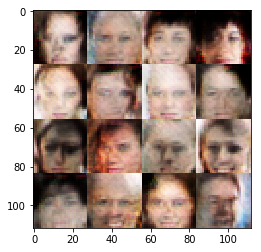

Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.7915... Total Loss: 2.0942
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.8703... Total Loss: 2.2941
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.8475... Total Loss: 2.1380
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.7866... Total Loss: 2.0722
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.8134... Total Loss: 2.2690
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.8726... Total Loss: 2.1680
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.8095... Total Loss: 2.0832
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7333... Total Loss: 2.1469
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.8450... Total Loss: 2.2209
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7448... Total Loss: 2.1486


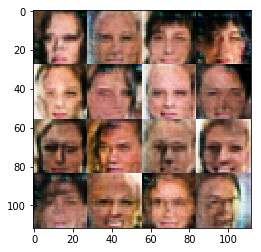

Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7440... Total Loss: 2.1912
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.6992... Total Loss: 2.1337
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.8647... Total Loss: 2.2084
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.6885... Total Loss: 2.0477
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.8680... Total Loss: 2.2676
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.8827... Total Loss: 2.2097
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.8401... Total Loss: 2.1781
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.8487... Total Loss: 2.3118
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.8117... Total Loss: 2.1611
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7624... Total Loss: 2.1922


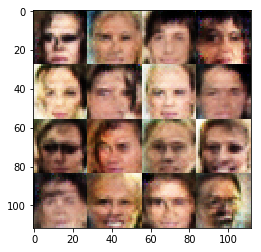

Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.7149... Total Loss: 2.1838
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7633... Total Loss: 2.1658
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.7932... Total Loss: 2.0717
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.8731... Total Loss: 2.2071
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.8086... Total Loss: 2.1841
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.8489... Total Loss: 2.1433
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.7411... Total Loss: 2.1805
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7682... Total Loss: 2.1492
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8320... Total Loss: 2.2004
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7736... Total Loss: 2.1717


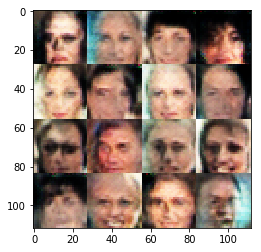

Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.7643... Total Loss: 2.0884
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8772... Total Loss: 2.2552
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7315... Total Loss: 2.1145
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.6275... Total Loss: 1.9962
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.7826... Total Loss: 2.1272
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.8177... Total Loss: 2.1988
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.8272... Total Loss: 2.2256
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.8272... Total Loss: 2.1351
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7973... Total Loss: 2.2155
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.8676... Total Loss: 2.2135


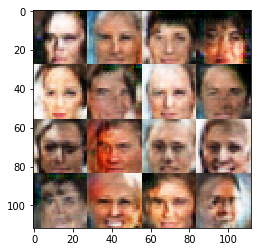

Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.8746... Total Loss: 2.2165
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.8732... Total Loss: 2.1517
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.6996... Total Loss: 2.1523
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.8012... Total Loss: 2.2118
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.8032... Total Loss: 2.0985
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 1.0923... Total Loss: 2.3307
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.6937... Total Loss: 2.0729
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.7871... Total Loss: 2.0986
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.8253... Total Loss: 2.2259
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7713... Total Loss: 2.1482


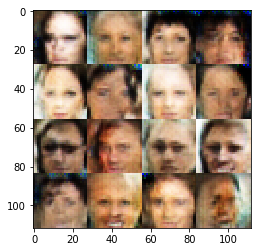

Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.8266... Total Loss: 2.2830
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.6398... Total Loss: 2.0956
Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.7398... Total Loss: 2.2630
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7853... Total Loss: 2.2009
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.7212... Total Loss: 2.0132
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.8742... Total Loss: 2.1931
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.7547... Total Loss: 2.0467
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8448... Total Loss: 2.2359
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.6947... Total Loss: 2.1176
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7886... Total Loss: 2.1757


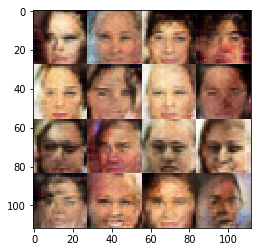

Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.8243... Total Loss: 2.1809
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.8171... Total Loss: 2.1379
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.8529... Total Loss: 2.2864
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7764... Total Loss: 2.1923
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.8087... Total Loss: 2.1204
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.9128... Total Loss: 2.2015
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.8973... Total Loss: 2.2576
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.7671... Total Loss: 2.0355
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7412... Total Loss: 2.1498
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7723... Total Loss: 2.1532


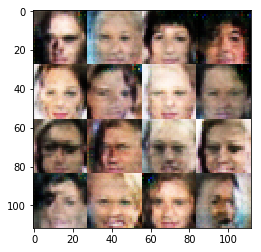

Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.7188... Total Loss: 2.0771
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.8260... Total Loss: 2.1375
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.7838... Total Loss: 2.1353
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.6948... Total Loss: 2.0759
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7694... Total Loss: 2.1269
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.8642... Total Loss: 2.2021
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7851... Total Loss: 2.1919
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7781... Total Loss: 2.1709
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.7447... Total Loss: 2.1916
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.8419... Total Loss: 2.2329


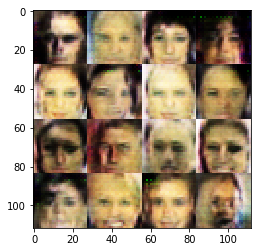

Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.6776... Total Loss: 2.1316
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.8797... Total Loss: 2.1542
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.8606... Total Loss: 2.2194
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.9099... Total Loss: 2.2028
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.6798... Total Loss: 2.1292
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.6954... Total Loss: 2.1238
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.7559... Total Loss: 2.0509
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.8186... Total Loss: 2.1854
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.8322... Total Loss: 2.1179
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.8975... Total Loss: 2.2805


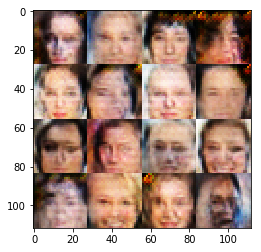

Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7648... Total Loss: 2.1638
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.8047... Total Loss: 2.1923
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.8265... Total Loss: 2.1436
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.8565... Total Loss: 2.1913
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.7278... Total Loss: 2.0906
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.7869... Total Loss: 2.1450
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.8372... Total Loss: 2.1695
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.9391... Total Loss: 2.3001
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.8038... Total Loss: 2.1414
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.8076... Total Loss: 2.1661


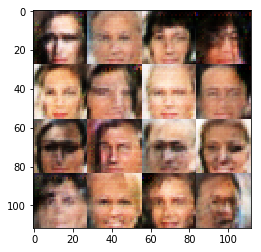

Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.8072... Total Loss: 2.1669
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.8488... Total Loss: 2.0790
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.8452... Total Loss: 2.1584
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.7913... Total Loss: 2.0619
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6155... Total Loss: 2.0786
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.8024... Total Loss: 2.2886
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7987... Total Loss: 2.1905
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.8086... Total Loss: 2.1044
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.8038... Total Loss: 2.1068
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.7278... Total Loss: 2.2096


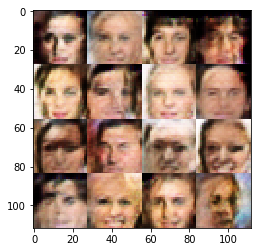

Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7969... Total Loss: 2.1778
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.8177... Total Loss: 2.1765
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.8342... Total Loss: 2.2081
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.8101... Total Loss: 2.1944
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.8343... Total Loss: 2.1494
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.8872... Total Loss: 2.1455
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.6607... Total Loss: 2.0067
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.8225... Total Loss: 2.1742
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7777... Total Loss: 2.1683
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.7606... Total Loss: 2.1211


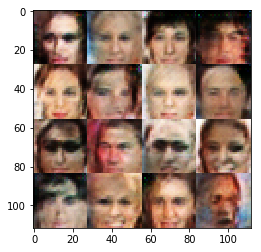

Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7053... Total Loss: 2.0931
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.9205... Total Loss: 2.1990
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.8393... Total Loss: 2.1918
Training finished.


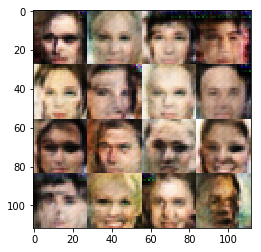

In [16]:
batch_size = 32
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.